In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

save_dir = 'figures/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

xls_file = "ConeSensitivity_Function_ForExercise2024.xls"
csv_file = "ConeSensitivity_new.csv"

if not os.path.exists(csv_file):
    assert os.path.exists(xls_file), f"File not exists: {xls_file}"
    df = pd.read_excel(xls_file)

    # Interpolate the data to have a finer wavelength resolution
    from scipy.interpolate import interp1d

    new_wavelengths = np.arange(df['Wavelength'].min(), df['Wavelength'].max() + 0.1, 0.5)  # 0.5 nm step
    interpolated_data = {'Wavelength': new_wavelengths}     # new data dict
    for col in df.columns[1:]:
        # kind='cubic' 表示三次样条插值（平滑曲线），kind='linear' 表示线性插值（折线）
        f = interp1d(df['Wavelength'], df[col], kind='cubic')   # smooth curve interpolation    
        interpolated_data[col] = f(new_wavelengths)
    df = pd.DataFrame(interpolated_data)
    # save to csv
    df.to_csv('ConeSensitivity_new.csv', index=False)
else:
    df = pd.read_csv(csv_file)

# print the basic info
print("shape:", df.shape)
print("columns:", df.columns.tolist())


shape: (891, 4)
columns: ['Wavelength', 'S_Cone_Sensitivity', 'M_Cone_Sensitivity', 'L_Cone_Sensitivity']


## A 
$$f_a(\lambda)$$

## B 

$$\overline{r}_a = I f_a(\lambda)$$

$$P(r_a|\mathbf{S}=(\lambda,I)) = \frac{(\overline{r}_a)^{r_a}}{r_a!} e^{-\overline{r}_a} = \exp\left(r_a \ln \overline{r}_a - \overline{r}_a - \sum_{i=1}^{r_a} \ln i \right)$$

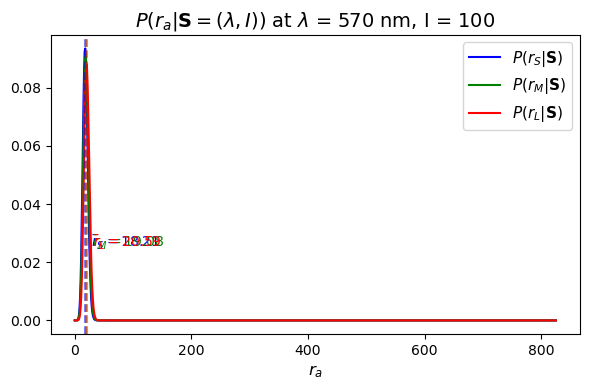

In [2]:
from math import factorial

def possion_prob(mu, ra):
    if ra > 0:
        return np.exp(ra * np.log(mu) - mu - sum(np.log(np.arange(1, ra + 1))))     # log form to avoid overflow
    else:
        return np.exp(- mu)
    
# def threshold_and_normalize(data, threshold=0.01):
#     """
#     将数组中小于阈值的元素设为零，然后归一化
#     """
#     # 将小于阈值的元素设为零
#     data_thresholded = np.where(data < threshold, 0, data)
    
#     # 归一化（确保总和为1）
#     total = data_thresholded.sum()
#     if total > 0:
#         data_normalized = data_thresholded / total
#     else:
#         data_normalized = data_thresholded  # 如果总和为0，保持原样
    
#     return data_normalized


I = 100
Lambda = 450   # nm

cones = ['S', 'M', 'L']

# turn into dict
avg_abs = {cone: {wavelen: I*sens for wavelen, sens in zip(df['Wavelength'], df[f'{cone}_Cone_Sensitivity'])} for cone in cones}

ra_list = np.arange(826)
prob_abs = {}
for cone, X_avg_abs in avg_abs.items():
    prob_abs_list = []
    for ra in ra_list:
        # prob_X_abs = (X_avg_abs[Lambda] ** ra) / factorial(ra) * np.exp(- X_avg_abs[Lambda])
        mu = X_avg_abs[Lambda]
        assert mu > 0, f"mu <= 0 for cone {cone} at lambda {Lambda} nm"
        prob_abs_list.append(possion_prob(mu, ra))
    prob_abs[cone] = np.array(prob_abs_list)

# normalize the prob_abs
prob_abs_normalized = {}
for cone in cones:
    #  prob_abs_normalized[cone] = threshold_and_normalize(prob_abs[cone], threshold=0.01)
    prob_abs_normalized[cone] = prob_abs[cone] / prob_abs[cone].sum()

plt.figure(figsize=(6, 4))
plt.plot(ra_list, prob_abs_normalized['S'], label=r'$P(r_S|\mathbf{S})$', color='blue')
plt.plot(ra_list, prob_abs_normalized['M'], label=r'$P(r_M|\mathbf{S})$', color='green')
plt.plot(ra_list, prob_abs_normalized['L'], label=r'$P(r_L|\mathbf{S})$', color='red')

# r_avg
plt.axvline(avg_abs['S'][Lambda], color='blue', linestyle='--', alpha=0.5)
plt.axvline(avg_abs['M'][Lambda], color='green', linestyle='--', alpha=0.5)
plt.axvline(avg_abs['L'][Lambda], color='red', linestyle='--', alpha=0.5)

plt.text(avg_abs['S'][Lambda]+10, 0.025, f'$\\bar{{r}}_S = {avg_abs["S"][Lambda]:.2f}$', color='blue', fontsize=10)
plt.text(avg_abs['M'][Lambda]+10, 0.025, f'$\\bar{{r}}_M = {avg_abs["M"][Lambda]:.2f}$', color='green', fontsize=10)
plt.text(avg_abs['L'][Lambda]+10, 0.025, f'$\\bar{{r}}_L = {avg_abs["L"][Lambda]:.2f}$', color='red', fontsize=10)

# plt.ylim(0, 1)
plt.xlabel(r'$r_a$', fontsize=12)
# plt.yscale('log')
plt.title(r'$P(r_a|\mathbf{S}=(\lambda,I))$ at $\lambda$ = 570 nm, I = 100', fontsize=14)
plt.legend(fontsize=11, loc='upper right')

plt.tight_layout()
# plt.savefig(save_dir + "Poisson_Distribution_At_570nm_100I.pdf")
plt.show()


## C

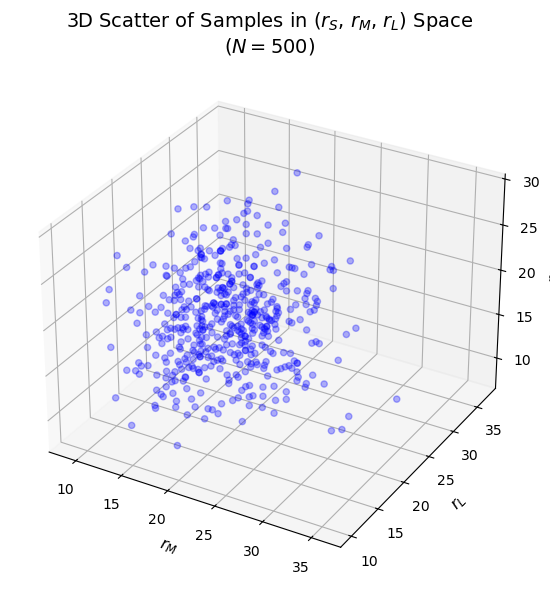

In [3]:
# Generate N_sample random samples according to distribution above
N_sample = 500
np.random.seed(42)

samples_vecs = np.zeros((len(cones), N_sample))
for i, cone in enumerate(cones):
    samples_vecs[i] = np.random.choice(ra_list, size=N_sample, p=prob_abs_normalized[cone])

# plot 3-D sapce of the samples
# %matplotlib inline
# %matplotlib widget

plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter(samples_vecs[1], samples_vecs[2], samples_vecs[0], color='blue', marker='o', alpha=0.3)
ax.set_zlabel(r'$r_S$', fontsize=12)
ax.set_xlabel(r'$r_M$', fontsize=12)
ax.set_ylabel(r'$r_L$', fontsize=12)
ax.set_title(f'3D Scatter of Samples in ($r_S$, $r_M$, $r_L$) Space\n($N={N_sample}$)', fontsize=14)
plt.tight_layout()
# plt.savefig(save_dir + "Scatter_3dSpace.pdf")
plt.show()


## D

$d\lambda \approx 13$ nm for about 30% overlaps, $d\lambda \approx 18$ nm for about 5% overlaps

In [33]:
# dLambda = 13  # nm
# save_fig_name = "Scatter_3dSpace_overlap_30_prime.pdf"

dLambda = 18  # nm
save_fig_name = "Scatter_3dSpace_overlap_5_prime.pdf"

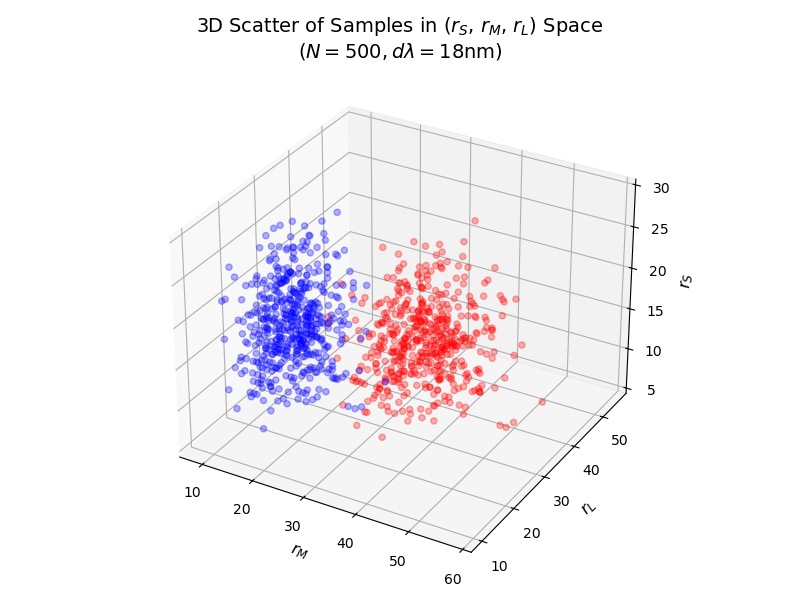

In [34]:
Lambda_prime = Lambda + dLambda

prob_abs_prime = {}
for cone, X_avg_abs in avg_abs.items():
    prob_abs_list = []
    for ra in ra_list:
        # prob_X_abs = (X_avg_abs[Lambda] ** ra) / factorial(ra) * np.exp(- X_avg_abs[Lambda])
        prob_abs_list.append(possion_prob(X_avg_abs[Lambda_prime], ra))
    prob_abs_prime[cone] = np.array(prob_abs_list)

# normalize the prob_abs
prob_abs_prime_normalized = {}
for cone in cones:
    prob_abs_prime_normalized[cone] = prob_abs_prime[cone] / prob_abs_prime[cone].sum()

# Generate 100 random samples according to distribution above
np.random.seed(42)

samples_vecs_prime = np.zeros((len(cones), N_sample))
for i, cone in enumerate(cones):
    samples_vecs_prime[i] = np.random.choice(ra_list, size=N_sample, p=prob_abs_prime_normalized[cone])

# plot 3-D sapce of the samples
%matplotlib inline
%matplotlib widget

plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter(samples_vecs_prime[1], samples_vecs_prime[2], samples_vecs_prime[0], marker='o', alpha=0.3, color= 'red')
ax.scatter(samples_vecs[1], samples_vecs[2], samples_vecs[0], marker='o', color='blue', alpha=0.3)
ax.set_zlabel(r'$r_S$', fontsize=12)
ax.set_xlabel(r'$r_M$', fontsize=12)
ax.set_ylabel(r'$r_L$', fontsize=12)
ax.set_title(f'3D Scatter of Samples in ($r_S$, $r_M$, $r_L$) Space\n($N={N_sample}, d\\lambda={dLambda}$nm)', fontsize=14)
plt.tight_layout()
plt.savefig(save_dir + save_fig_name)
plt.show()

## G

Likelihood of decoded results $\hat\lambda$
$$P(r_S, r_M,r_L|\mathbf{S}=(\hat\lambda,I)) = P(r_S|\mathbf{S}=(\hat\lambda,I))\cdot P(r_M|\mathbf{S}=(\hat\lambda,I)) \cdot P(r_L|\mathbf{S}=(\hat\lambda,I))$$

Peak Lambda: 449.0 with likelihood -8.400898396920379


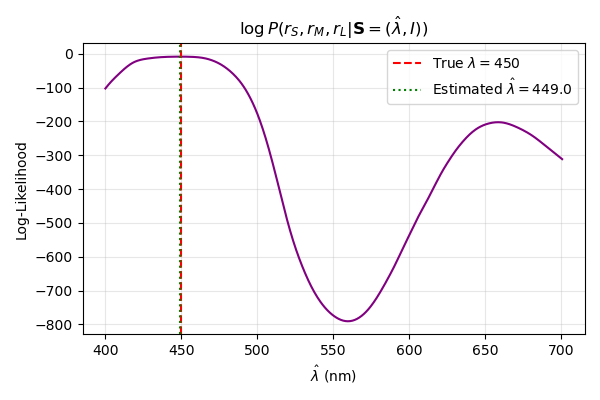

In [20]:
# randomly pick one sample
np.random.seed(42)
sample = samples_vecs[:, np.random.randint(N_sample)].astype(int)

hat_Lambda_list = np.arange(400, 701, 0.5)  # nm  (5nm steps due to data constrants)

likelihoods = np.zeros_like(hat_Lambda_list)
log_likelihoods = []

for i, hat_lambda in enumerate(hat_Lambda_list):
    # likelihood = 1.0
    log_likelihood = 0.0

    for j, ra in enumerate(sample):
        cone = cones[j]
        mu = avg_abs[cone][hat_lambda]
        assert mu > 0, f"mu <= 0 for cone {cone} at lambda {hat_lambda} nm"

        if ra != 0: 
            term = ra * np.log(mu) - mu - sum(np.log(np.arange(1, ra + 1)))
            prob_X_abs = np.exp(term)     # log form to avoid overflow
        else:
            term = - mu
            prob_X_abs = np.exp(term)
        # prob_X_abs = possion_prob(mu, ra)
        # likelihood *= prob_X_abs
        log_likelihood += term  # not `np.log(prob_X_abs)`, to avoid underflow
    # likelihoods[i] = likelihood
    log_likelihoods.append(log_likelihood)


# Find peak
peak_idx = np.argmax(log_likelihoods)
peak_lambda = hat_Lambda_list[peak_idx]
print(f"Peak Lambda: {peak_lambda} with likelihood {log_likelihoods[peak_idx]}")

# Plot
plt.figure(figsize=(6, 4))
plt.plot(hat_Lambda_list, log_likelihoods, color='purple')
plt.axvline(Lambda, color='red', linestyle='--', label=f'True $\\lambda={Lambda}$')
plt.axvline(peak_lambda, color='green', linestyle=':', label=f'Estimated $\\hat{{\\lambda}}={peak_lambda}$')
plt.xlabel(r'$\hat{\lambda}$ (nm)')
plt.ylabel('Log-Likelihood')
plt.title(r'$\log P(r_S, r_M, r_L |  \mathbf{S}=(\hat{\lambda},I))$')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig(save_dir + "log-likelihood.pdf")

# # plot likelihoods
# plt.figure(figsize=(6, 4))
# plt.plot(hat_Lambda_list, log_likelihoods, color='purple')
# plt.xlabel(r'$\hat{\lambda}$ (nm)', fontsize=12)
# # plt.yscale('log')
# plt.title(r'Log-Likelihood $P(r_S, r_M,r_L|\mathbf{S}=(\hat\lambda,I))$', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.xlim(hat_Lambda_list.min(), hat_Lambda_list.max())
# plt.tight_layout()


## H

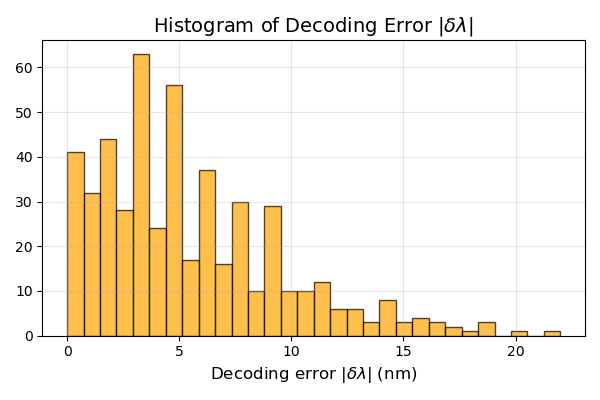

In [26]:
samples_vecs.astype(int)

delta_lambda_list = []

for sample in samples_vecs.T:
    sample = sample.astype(int)

    likelihoods = np.zeros_like(hat_Lambda_list)
    log_likelihoods = []

    for i, hat_lambda in enumerate(hat_Lambda_list):
        # likelihood = 1.0
        log_likelihood = 0.0

        for j, ra in enumerate(sample):
            cone = cones[j]
            mu = avg_abs[cone][hat_lambda]
            assert mu > 0, f"mu <= 0 for cone {cone} at lambda {hat_lambda} nm"
            if ra != 0: 
                term = ra * np.log(mu) - mu - sum(np.log(np.arange(1, ra + 1)))
                prob_X_abs = np.exp(term)     # log form to avoid overflow
            else:
                term = - mu
                prob_X_abs = np.exp(term)
            # likelihood *= prob_X_abs
            log_likelihood += term  # not `np.log(prob_X_abs)`, to avoid underflow
        # likelihoods[i] = likelihood
        log_likelihoods.append(log_likelihood)

    # Find peak
    peak_idx = np.argmax(log_likelihoods)
    peak_lambda = hat_Lambda_list[peak_idx]
    delta_lambda_list.append(abs(peak_lambda - Lambda)) 

# plot histogram of delta_lambda_list
plt.figure(figsize=(6, 4))
plt.hist(delta_lambda_list, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel(r'Decoding error $|\delta{\lambda}|$ (nm)', fontsize=12)
plt.title(r'Histogram of Decoding Error $|\delta{\lambda}|$', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(save_dir + "histogram_decoding_error_prime.pdf")